# Comparative Evaluation of Search Algorithms for Athlete Training Schedule Optimization

This notebook compares three different search algorithms applied to the athlete training schedule optimization problem:
1. **Constraint Satisfaction Problem (CSP)** with backtracking search
2. **Depth-First Search (DFS)**
3. **Breadth-First Search (BFS)**
4. **Uniform Cost Search (UCS)**
5. **A-star Search**
6. **Greedy Best-First Search**
7. **Genetic Algorithm**

We will compare these algorithms across several metrics:
- **Time Complexity**: Execution time
- **Space Complexity**: Memory usage and maximum frontier size
- **Solution Quality**: Performance level, fatigue management, and injury risk
- **Training Schedule Properties**: Rest/training balance, workout intensity distribution

## Setup and Imports

First, we'll import the necessary libraries and algorithms.

In [12]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tracemalloc

# Import our search algorithm implementations
from csp import AthleteTrainingCSP
from dfs_search import DFSSearch
from BFS_search import BFSSearch
from UCS_Search import UCSSearch
from A_star import AStarSearch
from greedy_search_implementation import GreedySearch
from Problem import AthletePerformanceProblem
from Genetic import GeneticAlgorithm as SimpleGeneticAlgorithm
from Genetic_akram import GeneticAlgorithm as AkramGeneticAlgorithm

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

## Define Common Parameters

To ensure a fair comparison, we'll use the same initial conditions and constraints for all algorithms.

In [13]:
# Common parameters for all search algorithms
INITIAL_STATE = (0, 1.5, 0.2, 5.5)  # day, fatigue, risk, performance
TARGET_DAY = 10                      # 10-day schedule
TARGET_PERF = 7.5                      # Target performance level
MAX_FATIGUE = 3.0                    # Maximum allowable fatigue
MAX_RISK = 0.35                       # Maximum allowable injury risk

# Time limit for CSP algorithm (in seconds)
CSP_TIME_LIMIT = 120

# Dictionary to store results
results = {}

## Helper Functions

Let's create some helper functions to standardize the evaluation process and results display.

In [14]:
def measure_performance(func):
    """Decorator to measure execution time and memory usage of a function"""
    def wrapper(*args, **kwargs):
        # Start memory tracking
        tracemalloc.start()
        
        # Start timing
        start_time = time.time()
        
        # Execute function
        result = func(*args, **kwargs)
        
        # End timing
        end_time = time.time()
        execution_time = end_time - start_time
        
        # Get memory usage
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        # Return results along with measurements
        return {
            'result': result,
            'execution_time': execution_time,
            'peak_memory': peak / 1024 / 1024  # Convert to MB
        }
    return wrapper

def evaluate_schedule(problem, actions, algorithm_name):
    """Evaluates a schedule and extracts metrics"""
    if not actions:
        print(f"No solution found for {algorithm_name}")
        return None
    
    # Initialize from the initial state
    state = problem.initial_state
    state_progression = [state]
    
    # Apply each action and track the state progression
    for action in actions:
        state = problem.apply_action(state, action)
        state_progression.append(state)
        
    # Extract metrics from the final state
    day, fatigue, risk, performance, _ = state_progression[-1]
    
    # Calculate additional metrics
    rest_days = sum(1 for action in actions if action[0] == 0.0)
    high_intensity_days = sum(1 for action in actions if action[0] >= 0.7)
    total_workload = sum(problem.LOAD_PER_MIN.get(action[0], 0) * action[1] for action in actions)
    
    # Compute state progression for plotting
    performance_progression = [s[3] for s in state_progression]
    fatigue_progression = [s[1] for s in state_progression]
    risk_progression = [s[2] for s in state_progression]
    
    return {
        'algorithm': algorithm_name,
        'final_day': day,
        'final_performance': performance,
        'final_fatigue': fatigue,
        'final_risk': risk,
        'goal_achieved': day >= TARGET_DAY and performance >= TARGET_PERF,
        'rest_days': rest_days,
        'high_intensity_days': high_intensity_days,
        'total_workload': total_workload,
        'actions': actions,
        'performance_progression': performance_progression,
        'fatigue_progression': fatigue_progression,
        'risk_progression': risk_progression
    }

## Run CSP Algorithm

First, we'll run the Constraint Satisfaction Problem (CSP) approach with backtracking search.

In [15]:
@measure_performance
def run_csp():
    problem = AthleteTrainingCSP(
        initial_state=INITIAL_STATE,
        target_day=TARGET_DAY,
        max_fatigue=MAX_FATIGUE,
        max_risk=MAX_RISK
    )
    
    solution = problem.backtracking_search(time_limit=CSP_TIME_LIMIT)
    
    # Return both solution and stats
    return {
        'solution': solution,
        'stats': problem.backtrack_stats
    }

# Run the CSP algorithm and measure its performance
print("Running CSP algorithm...")
csp_result = run_csp()
csp_solution = csp_result['result']['solution']
csp_stats = csp_result['result']['stats']

# Create temporary problem to evaluate final state
if csp_solution:
    temp_problem = AthletePerformanceProblem(initial_state=INITIAL_STATE, target_day=TARGET_DAY)
    current_state = temp_problem.initial_state
    for action in csp_solution:
        current_state = temp_problem.apply_action(current_state, action)
    day, fatigue, risk, performance, _ = current_state
    best_solution_msg = f"Performance: {performance:.2f}, Risk: {risk:.3f}, Fatigue: {fatigue:.2f}"
else:
    best_solution_msg = "No solution found"

print(f"CSP execution time: {csp_result['execution_time']:.2f} seconds")
print(f"CSP peak memory usage: {csp_result['peak_memory']:.2f} MB")
print(f"CSP backtracking iterations: {csp_stats['iterations']}")
print(f"CSP maximum depth reached: {csp_stats['max_depth']}")
print(f"Best solution found: {best_solution_msg}")

Running CSP algorithm...
First valid solution found in 3.81 seconds
Performance: 10.00
CSP execution time: 4.00 seconds
CSP peak memory usage: 17.30 MB
CSP backtracking iterations: 11
CSP maximum depth reached: 10
Best solution found: Performance: 10.00, Risk: 0.270, Fatigue: 2.56


## Run DFS Algorithm

In [16]:
@measure_performance
def run_dfs():
    problem = AthletePerformanceProblem(
        initial_state=INITIAL_STATE,
        target_day=TARGET_DAY
    )
    
    searcher = DFSSearch(problem)
    searcher.problem.target_day = TARGET_DAY
    searcher.problem.target_perf = TARGET_PERF
    searcher.problem.max_fatigue = MAX_FATIGUE
    searcher.problem.max_risk = MAX_RISK
    
    goal_node = searcher.search()
    
    if goal_node is None:
        print("DFS found no solution")
        path = []
    else:
        path = searcher.reconstruct_path(goal_node)
    
    # Return both solution and stats
    return {
        'path': path,
        'expanded_nodes': searcher.expanded_nodes,
        'max_stack_size': searcher.max_stack_size
    }

# Run the DFS algorithm and measure its performance
print("Running DFS algorithm...")
dfs_result = run_dfs()
dfs_path = dfs_result['result']['path']
dfs_expanded_nodes = dfs_result['result']['expanded_nodes']
dfs_max_stack_size = dfs_result['result']['max_stack_size']

# Create temporary problem to evaluate final state
if dfs_path:
    temp_problem = AthletePerformanceProblem(initial_state=INITIAL_STATE, target_day=TARGET_DAY)
    current_state = temp_problem.initial_state
    for action in dfs_path:
        current_state = temp_problem.apply_action(current_state, action)
    day, fatigue, risk, performance, _ = current_state
    best_solution_msg = f"Performance: {performance:.2f}, Risk: {risk:.3f}, Fatigue: {fatigue:.2f}"
else:
    best_solution_msg = "No solution found"

print(f"DFS execution time: {dfs_result['execution_time']:.2f} seconds")
print(f"DFS peak memory usage: {dfs_result['peak_memory']:.2f} MB")
print(f"DFS nodes expanded: {dfs_expanded_nodes}")
print(f"DFS maximum stack size: {dfs_max_stack_size}")
print(f"Best solution found: {best_solution_msg}")

Running DFS algorithm...
Explored 100 nodes, stack size: 46, Current state: Day 10, F=2.32, R=0.16, P=3.25, Depth=10
Explored 200 nodes, stack size: 55, Current state: Day 9, F=2.20, R=0.18, P=2.12, Depth=9
Explored 300 nodes, stack size: 46, Current state: Day 10, F=2.72, R=0.24, P=2.70, Depth=10
Explored 400 nodes, stack size: 47, Current state: Day 9, F=2.51, R=0.17, P=3.53, Depth=9
Explored 500 nodes, stack size: 52, Current state: Day 9, F=2.18, R=0.21, P=3.05, Depth=9
Explored 600 nodes, stack size: 49, Current state: Day 9, F=2.60, R=0.21, P=2.05, Depth=9
Explored 700 nodes, stack size: 43, Current state: Day 10, F=2.23, R=0.28, P=3.39, Depth=10
Explored 800 nodes, stack size: 40, Current state: Day 10, F=2.61, R=0.16, P=4.36, Depth=10
Explored 900 nodes, stack size: 39, Current state: Day 10, F=2.29, R=0.20, P=4.11, Depth=10
Explored 1000 nodes, stack size: 46, Current state: Day 9, F=2.85, R=0.19, P=3.79, Depth=9
Explored 1100 nodes, stack size: 39, Current state: Day 10, F=2.

## Run BFS Algorithm

Now we'll run the Breadth-First Search (BFS) approach to find an optimal training schedule.

In [17]:
@measure_performance
def run_bfs():
    problem = AthletePerformanceProblem(
        initial_state=INITIAL_STATE,
        target_day=TARGET_DAY
    )
    
    searcher = BFSSearch(problem)
    searcher.problem.target_day = TARGET_DAY
    searcher.problem.target_perf = TARGET_PERF
    searcher.problem.max_fatigue = MAX_FATIGUE
    searcher.problem.max_risk = MAX_RISK
    
    goal_node = searcher.search()
    
    if goal_node is None:
        print("BFS found no solution")
        path = []
    else:
        path = searcher.reconstruct_path(goal_node)
    
    # Return both solution and stats
    return {
        'path': path,
        'expanded_nodes': searcher.expanded_nodes,
        'max_queue_size': searcher.max_queue_size
    }

# Run the BFS algorithm and measure its performance
print("Running BFS algorithm...")
bfs_result = run_bfs()
bfs_path = bfs_result['result']['path']
bfs_expanded_nodes = bfs_result['result']['expanded_nodes']
bfs_max_queue_size = bfs_result['result']['max_queue_size']

# Create temporary problem to evaluate final state
if bfs_path:
    temp_problem = AthletePerformanceProblem(initial_state=INITIAL_STATE, target_day=TARGET_DAY)
    current_state = temp_problem.initial_state
    for action in bfs_path:
        current_state = temp_problem.apply_action(current_state, action)
    day, fatigue, risk, performance, _ = current_state
    best_solution_msg = f"Performance: {performance:.2f}, Risk: {risk:.3f}, Fatigue: {fatigue:.2f}"
else:
    best_solution_msg = "No solution found"

print(f"BFS execution time: {bfs_result['execution_time']:.2f} seconds")
print(f"BFS peak memory usage: {bfs_result['peak_memory']:.2f} MB")
print(f"BFS nodes expanded: {bfs_expanded_nodes}")
print(f"BFS maximum queue size: {bfs_max_queue_size}")
print(f"Best solution found: {best_solution_msg}")

Running BFS algorithm...
Explored 500 nodes, queue size: 2586
Explored 1000 nodes, queue size: 4770
Explored 1500 nodes, queue size: 6222
Explored 2000 nodes, queue size: 8197
Explored 2500 nodes, queue size: 9312
Explored 3000 nodes, queue size: 10017
Explored 3500 nodes, queue size: 11445
Explored 4000 nodes, queue size: 12123
Explored 4500 nodes, queue size: 12027
Explored 5000 nodes, queue size: 12694
Explored 5500 nodes, queue size: 14307
Explored 6000 nodes, queue size: 15462
Explored 6500 nodes, queue size: 15582
Explored 7000 nodes, queue size: 15590
Explored 7500 nodes, queue size: 16504
Explored 8000 nodes, queue size: 17342
Explored 8500 nodes, queue size: 18983
Explored 9000 nodes, queue size: 19176
Explored 9500 nodes, queue size: 19251
Explored 10000 nodes, queue size: 19844
Explored 10500 nodes, queue size: 20317
BFS execution time: 4779.34 seconds
BFS peak memory usage: 27.15 MB
BFS nodes expanded: 10929
BFS maximum queue size: 20667
Best solution found: Performance: 10

## Run UCS Algorithm

Now we'll run the Uniform Cost Search (UCS) which expands nodes based on path cost.

In [18]:
@measure_performance
def run_ucs():
    problem = AthletePerformanceProblem(
        initial_state=INITIAL_STATE,
        target_day=TARGET_DAY
    )
    
    searcher = UCSSearch(problem)
    searcher.problem.target_day = TARGET_DAY
    searcher.problem.target_perf = TARGET_PERF
    searcher.problem.max_fatigue = MAX_FATIGUE
    searcher.problem.max_risk = MAX_RISK
    
    goal_node = searcher.search()
    
    if goal_node is None:
        print("UCS found no solution")
        path = []
    else:
        path = searcher.reconstruct_path(goal_node)
    
    # Return both solution and stats
    return {
        'path': path,
        'expanded_nodes': searcher.expanded_nodes,
        'max_queue_size': searcher.max_queue_size
    }

# Run the UCS algorithm and measure its performance
print("Running UCS algorithm...")
ucs_result = run_ucs()
ucs_path = ucs_result['result']['path']
ucs_expanded_nodes = ucs_result['result']['expanded_nodes']
ucs_max_queue_size = ucs_result['result']['max_queue_size']

# Create temporary problem to evaluate final state
if ucs_path:
    temp_problem = AthletePerformanceProblem(initial_state=INITIAL_STATE, target_day=TARGET_DAY)
    current_state = temp_problem.initial_state
    for action in ucs_path:
        current_state = temp_problem.apply_action(current_state, action)
    day, fatigue, risk, performance, _ = current_state
    best_solution_msg = f"Performance: {performance:.2f}, Risk: {risk:.3f}, Fatigue: {fatigue:.2f}"
else:
    best_solution_msg = "No solution found"

print(f"UCS execution time: {ucs_result['execution_time']:.2f} seconds")
print(f"UCS peak memory usage: {ucs_result['peak_memory']:.2f} MB")
print(f"UCS nodes expanded: {ucs_expanded_nodes}")
print(f"UCS maximum queue size: {ucs_max_queue_size}")
print(f"Best solution found: {best_solution_msg}")

Running UCS algorithm...
Explored 200 nodes, queue size: 1143
Explored 400 nodes, queue size: 2250
Explored 600 nodes, queue size: 3323
Explored 800 nodes, queue size: 4408
Explored 1000 nodes, queue size: 5388
Explored 1200 nodes, queue size: 6370
Explored 1400 nodes, queue size: 7362
UCS execution time: 1421.74 seconds
UCS peak memory usage: 17.30 MB
UCS nodes expanded: 1569
UCS maximum queue size: 8190
Best solution found: Performance: 8.78, Risk: 0.189, Fatigue: 2.10


## Run A* Search Algorithm

Now we'll run the A* Search which uses a combination of path cost and heuristic to find an optimal solution.

In [19]:
@measure_performance
def run_astar():
    problem = AthletePerformanceProblem(
        initial_state=INITIAL_STATE,
        target_day=TARGET_DAY
    )
    
    searcher = AStarSearch(problem)
    searcher.problem.target_day = TARGET_DAY
    searcher.problem.target_perf = TARGET_PERF
    searcher.problem.max_fatigue = MAX_FATIGUE
    searcher.problem.max_risk = MAX_RISK
    
    goal_node = searcher.search()
    
    if goal_node is None:
        print("A* search found no solution")
        path = []
    else:
        path = searcher.reconstruct_path(goal_node)
    
    # Return both solution and stats
    return {
        'path': path,
        'expanded_nodes': searcher.expanded_nodes,
        'max_queue_size': searcher.max_queue_size
    }

# Run the A* Search algorithm and measure its performance
print("Running A* Search algorithm...")
astar_result = run_astar()
astar_path = astar_result['result']['path']
astar_expanded_nodes = astar_result['result']['expanded_nodes']
astar_max_queue_size = astar_result['result']['max_queue_size']

# Create temporary problem to evaluate final state
if astar_path:
    temp_problem = AthletePerformanceProblem(initial_state=INITIAL_STATE, target_day=TARGET_DAY)
    current_state = temp_problem.initial_state
    for action in astar_path:
        current_state = temp_problem.apply_action(current_state, action)
    day, fatigue, risk, performance, _ = current_state
    best_solution_msg = f"Performance: {performance:.2f}, Risk: {risk:.3f}, Fatigue: {fatigue:.2f}"
else:
    best_solution_msg = "No solution found"

print(f"A* Search execution time: {astar_result['execution_time']:.2f} seconds")
print(f"A* Search peak memory usage: {astar_result['peak_memory']:.2f} MB")
print(f"A* Search nodes expanded: {astar_expanded_nodes}")
print(f"A* Search maximum queue size: {astar_max_queue_size}")
print(f"Best solution found: {best_solution_msg}")

Running A* Search algorithm...
Expanded 100 nodes, queue size: 546, time: 50.6s
Expanded 200 nodes, queue size: 1064, time: 105.1s
ML prediction cache: 1477 hits, 1477 misses
A* Search execution time: 113.19 seconds
A* Search peak memory usage: 17.30 MB
A* Search nodes expanded: 211
A* Search maximum queue size: 1123
Best solution found: Performance: 9.10, Risk: 0.189, Fatigue: 1.86


## Run Greedy Search Algorithm

In [20]:
@measure_performance
def run_greedy():
    problem = AthletePerformanceProblem(
        initial_state=INITIAL_STATE,
        target_day=TARGET_DAY
    )
    
    searcher = GreedySearch(problem)
    searcher.problem.target_day = TARGET_DAY
    searcher.problem.target_perf = TARGET_PERF
    searcher.problem.max_fatigue = MAX_FATIGUE
    searcher.problem.max_risk = MAX_RISK
    
    goal_node = searcher.search()
    
    if goal_node is None:
        print("Greedy search found no solution")
        path = []
    else:
        path = searcher.reconstruct_path(goal_node)
    
    # Return both solution and stats
    return {
        'path': path,
        'expanded_nodes': searcher.expanded_nodes,
        'max_queue_size': searcher.max_queue_size
    }

# Run the Greedy Search algorithm and measure its performance
print("Running Greedy Search algorithm...")
greedy_result = run_greedy()
greedy_path = greedy_result['result']['path']
greedy_expanded_nodes = greedy_result['result']['expanded_nodes']
greedy_max_queue_size = greedy_result['result']['max_queue_size']

# Create temporary problem to evaluate final state
if greedy_path:
    temp_problem = AthletePerformanceProblem(initial_state=INITIAL_STATE, target_day=TARGET_DAY)
    current_state = temp_problem.initial_state
    for action in greedy_path:
        current_state = temp_problem.apply_action(current_state, action)
    day, fatigue, risk, performance, _ = current_state
    best_solution_msg = f"Performance: {performance:.2f}, Risk: {risk:.3f}, Fatigue: {fatigue:.2f}"
else:
    best_solution_msg = "No solution found"

print(f"Greedy execution time: {greedy_result['execution_time']:.2f} seconds")
print(f"Greedy peak memory usage: {greedy_result['peak_memory']:.2f} MB")
print(f"Greedy nodes expanded: {greedy_expanded_nodes}")
print(f"Greedy maximum queue size: {greedy_max_queue_size}")
print(f"Best solution found: {best_solution_msg}")

Running Greedy Search algorithm...
Greedy execution time: 8.89 seconds
Greedy peak memory usage: 17.30 MB
Greedy nodes expanded: 14
Greedy maximum queue size: 85
Best solution found: Performance: 8.26, Risk: 0.180, Fatigue: 2.29


## Run Genetic Algorithm

Now, we'll run the Genetic Algorithm from Genetic_akram.py to optimize the athlete training schedule.

In [21]:
# @measure_performance
# def run_genetic():
#     # Create athlete performance problem instance with genetic flag
#     problem = AthletePerformanceProblem(
#         initial_state=INITIAL_STATE,
#         genetic=True  # Flag to use genetic-specific implementation
#     )
    
#     # Set target parameters for the problem
#     problem.target_day = TARGET_DAY
#     problem.target_perf = TARGET_PERF
#     problem.max_fatigue = MAX_FATIGUE
#     problem.max_risk = MAX_RISK
    
#     # Create the genetic algorithm instance
#     ga = AkramGeneticAlgorithm(
#         problem=problem,
#         population_size=100,  # Size of the population
#         num_generations=30,   # Number of generations to run
#         mutation_rate=0.05    # Mutation rate
#     )
    
#     # Run the genetic algorithm
#     best_schedule, best_fitness = ga.run()
    
#     return {
#         'schedule': best_schedule,
#         'fitness': best_fitness,
#         'ga_instance': ga
#     }

# # Run the Genetic Algorithm and measure its performance
# print("Running Genetic Algorithm...")
# genetic_result = run_genetic()
# genetic_schedule = genetic_result['result']['schedule']
# genetic_fitness = genetic_result['result']['fitness']
# genetic_ga_instance = genetic_result['result']['ga_instance']

# # Extract fitness metrics (assuming they're returned in the order performance, risk, fatigue)
# performance, risk, fatigue = genetic_fitness

# print(f"Genetic execution time: {genetic_result['execution_time']:.2f} seconds")
# print(f"Genetic peak memory usage: {genetic_result['peak_memory']:.2f} MB")
# print(f"Genetic Algorithm cache size: {len(genetic_ga_instance.state_cache) if hasattr(genetic_ga_instance, 'state_cache') else 'N/A'} states evaluated")
# print(f"Best solution found: Performance: {performance:.2f}, Risk: {risk:.3f}, Fatigue: {fatigue:.2f}")

## Evaluate Solution Quality

Now that we have solutions from all three algorithms, let's evaluate their quality.

In [22]:
# Create a common problem instance for evaluation
eval_problem = AthletePerformanceProblem(
    initial_state=INITIAL_STATE,
    target_day=TARGET_DAY
)
# Set additional attributes after creation
eval_problem.target_perf = TARGET_PERF
eval_problem.max_fatigue = MAX_FATIGUE
eval_problem.max_risk = MAX_RISK

# Evaluate each solution
csp_evaluation = evaluate_schedule(eval_problem, csp_solution, "CSP")
dfs_evaluation = evaluate_schedule(eval_problem, dfs_path, "DFS")
bfs_evaluation = evaluate_schedule(eval_problem, bfs_path, "BFS")
ucs_evaluation = evaluate_schedule(eval_problem, ucs_path, "UCS")
greedy_evaluation = evaluate_schedule(eval_problem, greedy_path, "Greedy")
astar_evaluation = evaluate_schedule(eval_problem, astar_path, "A*")
# genetic_evaluation = evaluate_schedule(eval_problem, genetic_schedule, "Genetic")

# Combine all evaluations into a list for comparison
evaluations = []
if csp_evaluation:
    evaluations.append(csp_evaluation)
if dfs_evaluation:
    evaluations.append(dfs_evaluation)
if bfs_evaluation:
    evaluations.append(bfs_evaluation)
if ucs_evaluation:
    evaluations.append(ucs_evaluation)
if greedy_evaluation:
    evaluations.append(greedy_evaluation)
if astar_evaluation:
    evaluations.append(astar_evaluation)
# if genetic_evaluation:
#     evaluations.append(genetic_evaluation)

# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame([
    {
        'Algorithm': eval['algorithm'],
        'Final Performance': round(eval['final_performance'], 2),
        'Final Fatigue': round(eval['final_fatigue'], 2),
        'Final Risk': round(eval['final_risk'], 3),
        'Goal Achieved': eval['goal_achieved'],
        'Rest Days': eval['rest_days'],
        'High Intensity Days': eval['high_intensity_days'],
        'Total Workload': round(eval['total_workload'], 2)
    }
    for eval in evaluations
])

# Display the comparison
comparison_df

,Algorithm,Final Performance,Final Fatigue,Final Risk,Goal Achieved,Rest Days,High Intensity Days,Total Workload
0,CSP,10.00,2.56,0.270,True,0,4,4446.68
1,DFS,7.78,2.39,0.219,True,3,1,1781.31
2,BFS,10.00,2.63,0.260,True,0,0,2263.76
3,UCS,8.78,2.10,0.189,True,1,3,3867.44
4,Greedy,8.26,2.29,0.180,True,2,1,3558.58
5,A*,9.10,1.86,0.189,True,1,2,3558.58


## Time and Space Complexity Comparison

Let's compare the computational efficiency of the three algorithms.

In [23]:
# Create DataFrame for algorithm performance metrics
performance_df = pd.DataFrame([
    {
        'Algorithm': 'CSP',
        'Execution Time (s)': csp_result['execution_time'],
        'Peak Memory (MB)': csp_result['peak_memory'],
        'Nodes Expanded': csp_stats['iterations'],
        'Max Frontier Size': 'N/A (Recursive)'
    },
    {
        'Algorithm': 'DFS',
        'Execution Time (s)': dfs_result['execution_time'],
        'Peak Memory (MB)': dfs_result['peak_memory'],
        'Nodes Expanded': dfs_expanded_nodes,
        'Max Frontier Size': dfs_max_stack_size
    },
    {
        'Algorithm': 'BFS',
        'Execution Time (s)': bfs_result['execution_time'],
        'Peak Memory (MB)': bfs_result['peak_memory'],
        'Nodes Expanded': bfs_expanded_nodes,
        'Max Frontier Size': bfs_max_queue_size
    },
    {
        'Algorithm': 'UCS',
        'Execution Time (s)': ucs_result['execution_time'],
        'Peak Memory (MB)': ucs_result['peak_memory'],
        'Nodes Expanded': ucs_expanded_nodes,
        'Max Frontier Size': ucs_max_queue_size
    },
    {
        'Algorithm': 'Greedy',
        'Execution Time (s)': greedy_result['execution_time'],
        'Peak Memory (MB)': greedy_result['peak_memory'],
        'Nodes Expanded': greedy_expanded_nodes,
        'Max Frontier Size': greedy_max_queue_size
    },
    {
        'Algorithm': 'A*',
        'Execution Time (s)': astar_result['execution_time'],
        'Peak Memory (MB)': astar_result['peak_memory'],
        'Nodes Expanded': astar_expanded_nodes,
        'Max Frontier Size': astar_max_queue_size
    }
    # {
    #     'Algorithm': 'Genetic',
    #     'Execution Time (s)': genetic_result['execution_time'],
    #     'Peak Memory (MB)': genetic_result['peak_memory'],
    #     'Nodes Expanded': 'N/A',
    #     'Max Frontier Size': 'N/A'
    # }
])

# Display the performance comparison
performance_df

,Algorithm,Execution Time (s),Peak Memory (MB),Nodes Expanded,Max Frontier Size
0,CSP,3.996048,17.300195,11,N/A (Recursive)
1,DFS,1616.451193,17.300025,3826,61
2,BFS,4779.344831,27.148178,10929,20667
3,UCS,1421.737985,17.300606,1569,8190
4,Greedy,8.890083,17.300207,14,85
5,A*,113.193349,17.299383,211,1123


## Visualization

Let's visualize the comparison between algorithms using various plots.

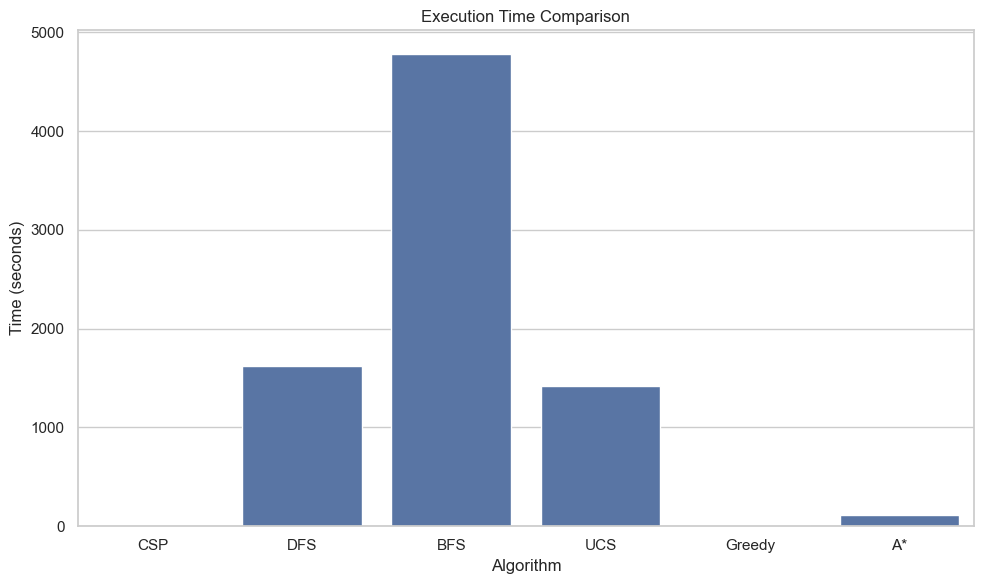

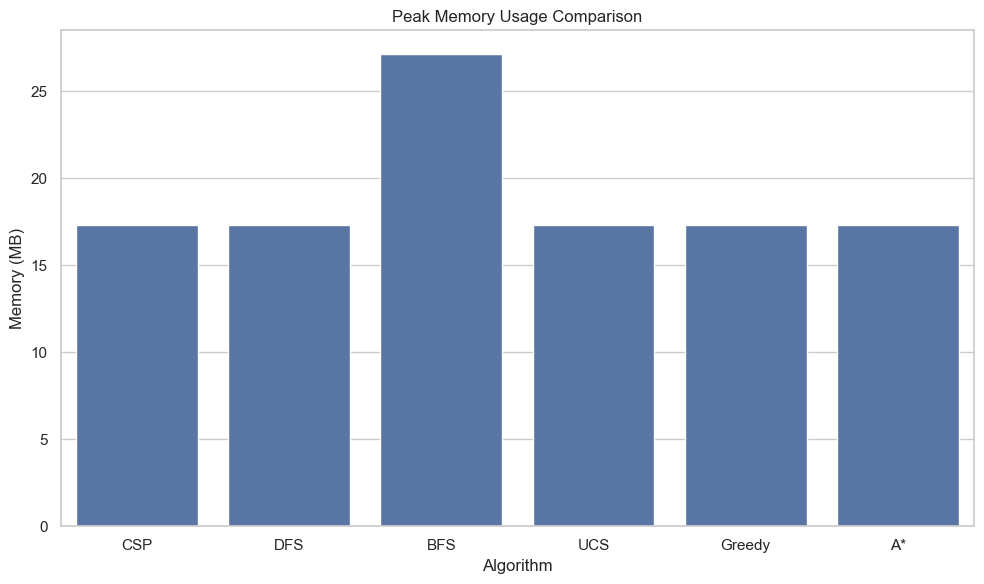

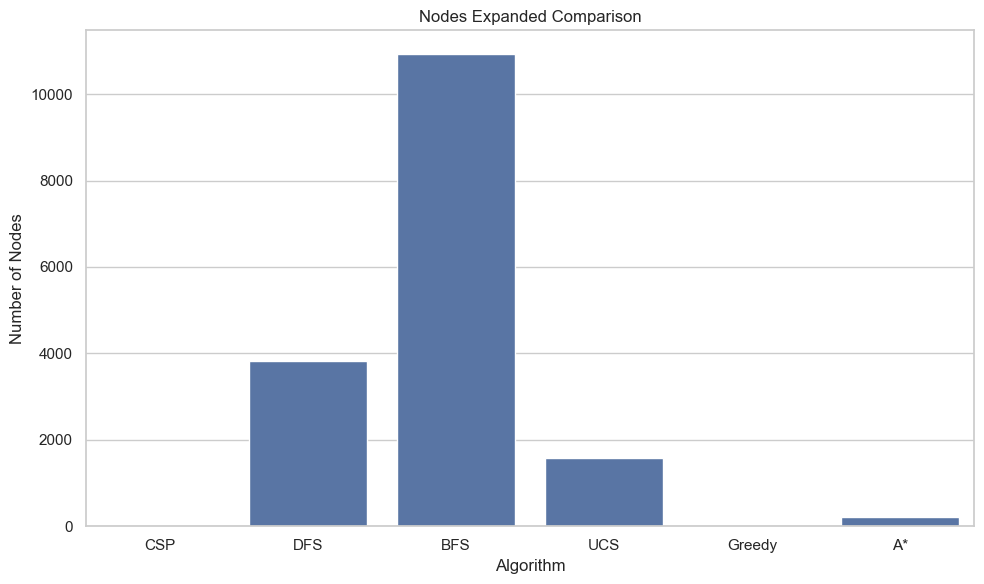

In [24]:
# Plot execution time comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Algorithm', y='Execution Time (s)', data=performance_df)
plt.title('Execution Time Comparison')
plt.ylabel('Time (seconds)')
plt.tight_layout()
plt.show()

# Plot memory usage comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Algorithm', y='Peak Memory (MB)', data=performance_df)
plt.title('Peak Memory Usage Comparison')
plt.ylabel('Memory (MB)')
plt.tight_layout()
plt.show()

# Plot nodes expanded comparison
plt.figure(figsize=(10, 6))
numeric_nodes = pd.DataFrame([
    {'Algorithm': algo, 'Nodes Expanded': nodes if isinstance(nodes, (int, float)) else 0}
    for algo, nodes in zip(performance_df['Algorithm'], performance_df['Nodes Expanded'])
])
sns.barplot(x='Algorithm', y='Nodes Expanded', data=numeric_nodes)
plt.title('Nodes Expanded Comparison')
plt.ylabel('Number of Nodes')
plt.tight_layout()
plt.show()

## Solution Quality Visualization

Let's visualize how the performance, fatigue, and risk metrics change over the training period for each algorithm.

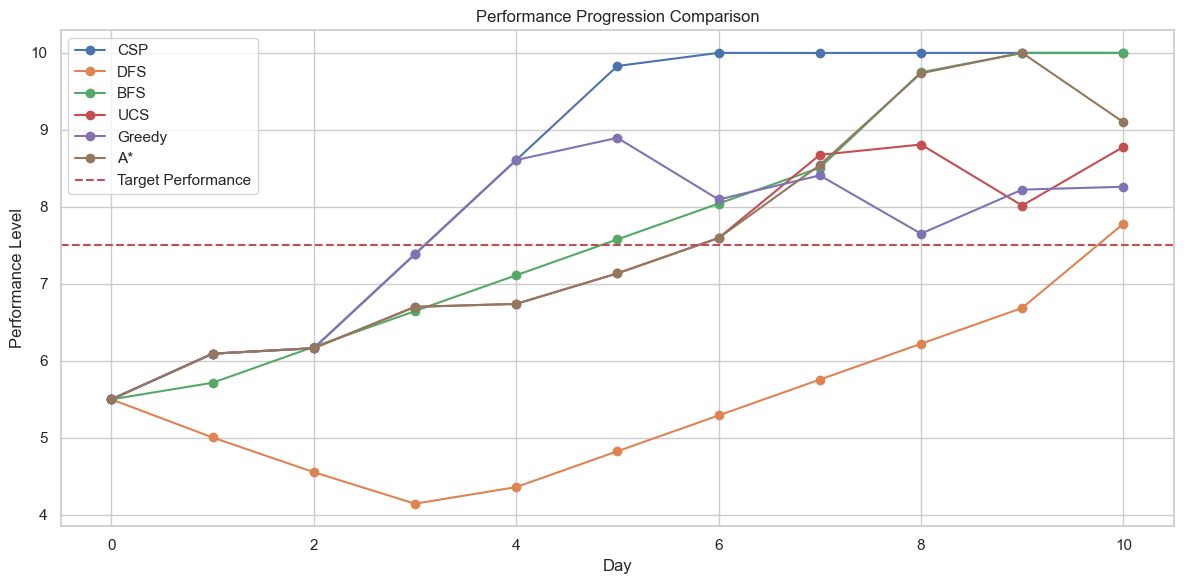

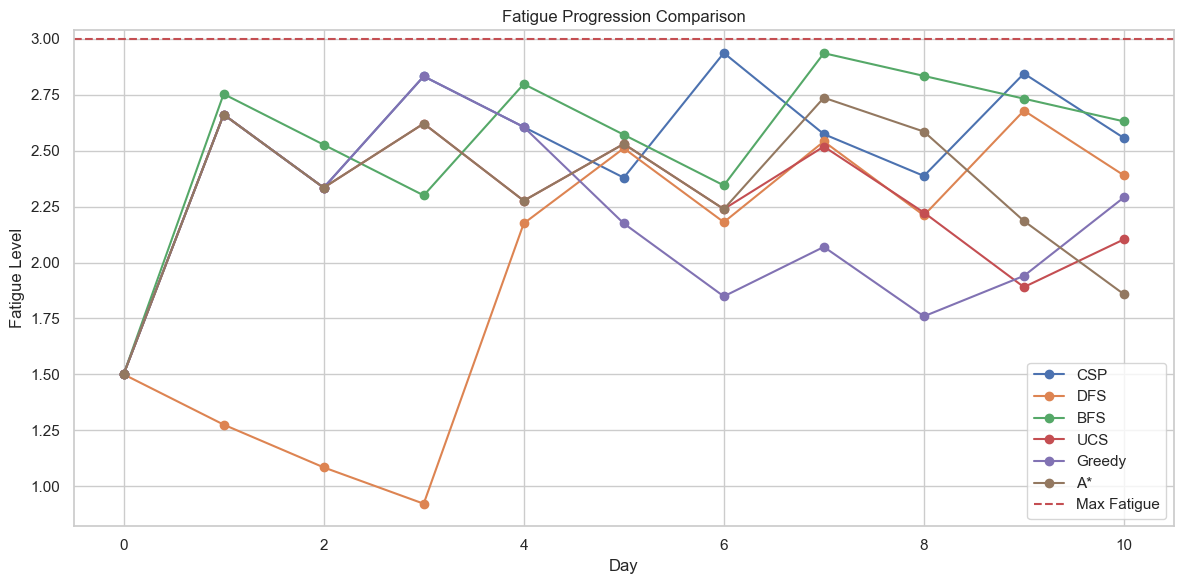

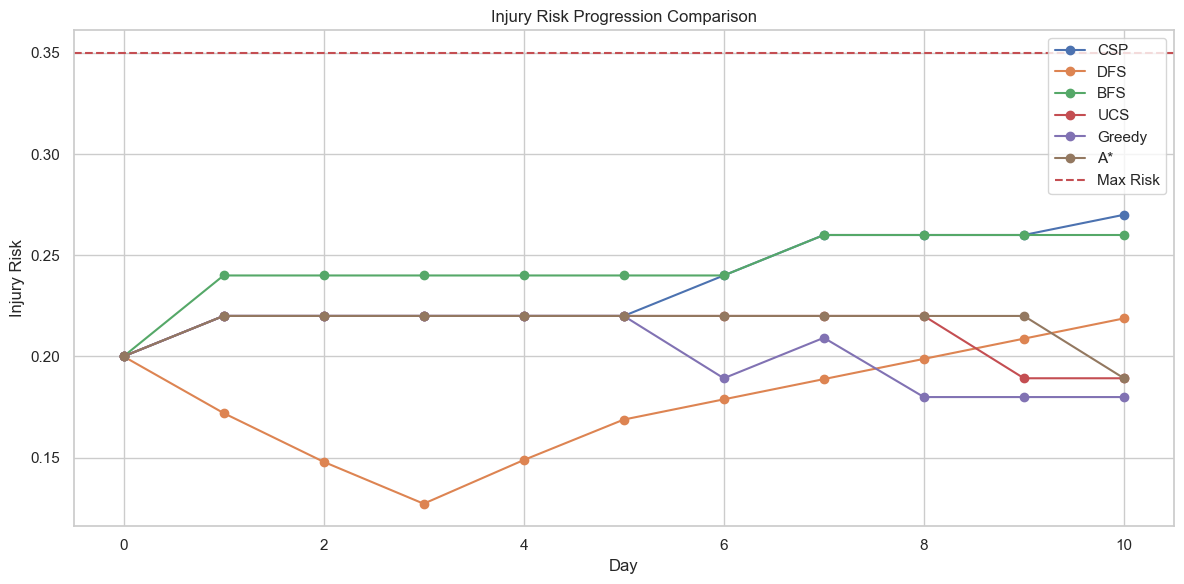

In [25]:
# Plot performance progression
plt.figure(figsize=(12, 6))
for eval in evaluations:
    days = list(range(len(eval['performance_progression'])))
    plt.plot(days, eval['performance_progression'], marker='o', label=eval['algorithm'])

plt.axhline(y=TARGET_PERF, color='r', linestyle='--', label='Target Performance')
plt.title('Performance Progression Comparison')
plt.xlabel('Day')
plt.ylabel('Performance Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot fatigue progression
plt.figure(figsize=(12, 6))
for eval in evaluations:
    days = list(range(len(eval['fatigue_progression'])))
    plt.plot(days, eval['fatigue_progression'], marker='o', label=eval['algorithm'])

plt.axhline(y=MAX_FATIGUE, color='r', linestyle='--', label='Max Fatigue')
plt.title('Fatigue Progression Comparison')
plt.xlabel('Day')
plt.ylabel('Fatigue Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot risk progression
plt.figure(figsize=(12, 6))
for eval in evaluations:
    days = list(range(len(eval['risk_progression'])))
    plt.plot(days, eval['risk_progression'], marker='o', label=eval['algorithm'])

plt.axhline(y=MAX_RISK, color='r', linestyle='--', label='Max Risk')
plt.title('Injury Risk Progression Comparison')
plt.xlabel('Day')
plt.ylabel('Injury Risk')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Training Schedule Visualization

Let's visualize the actual training schedules produced by each algorithm.

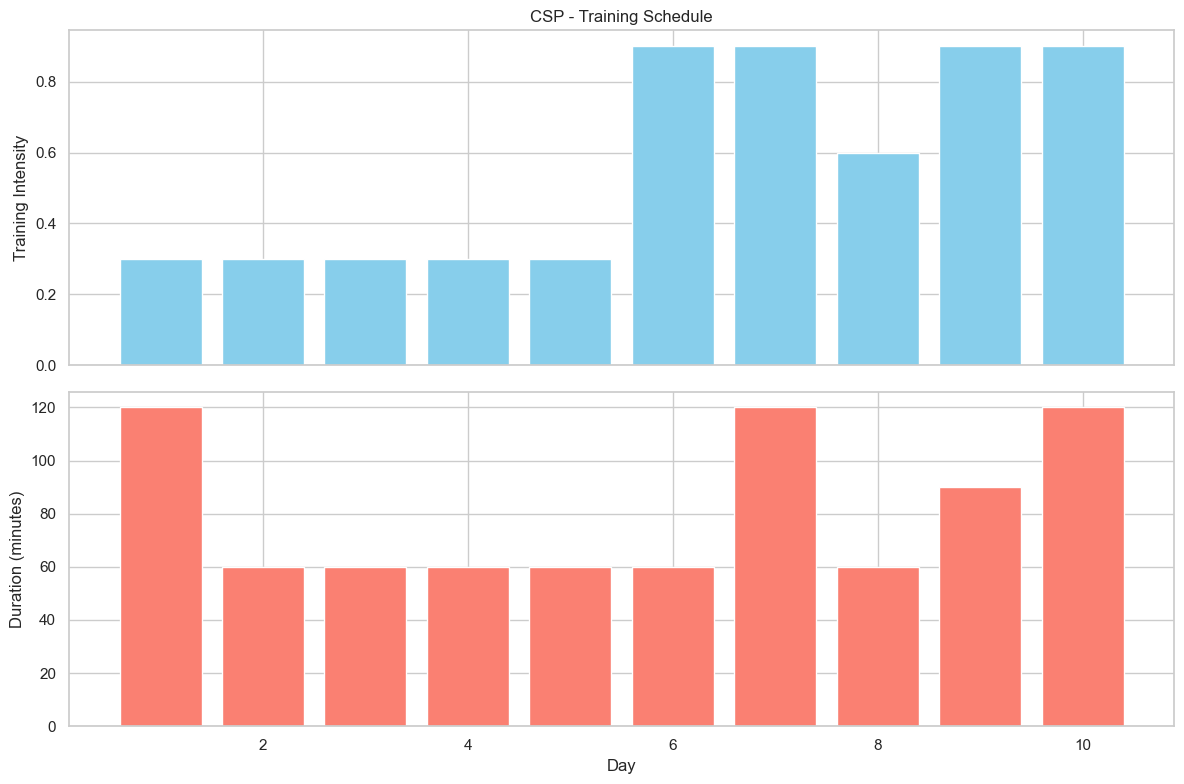

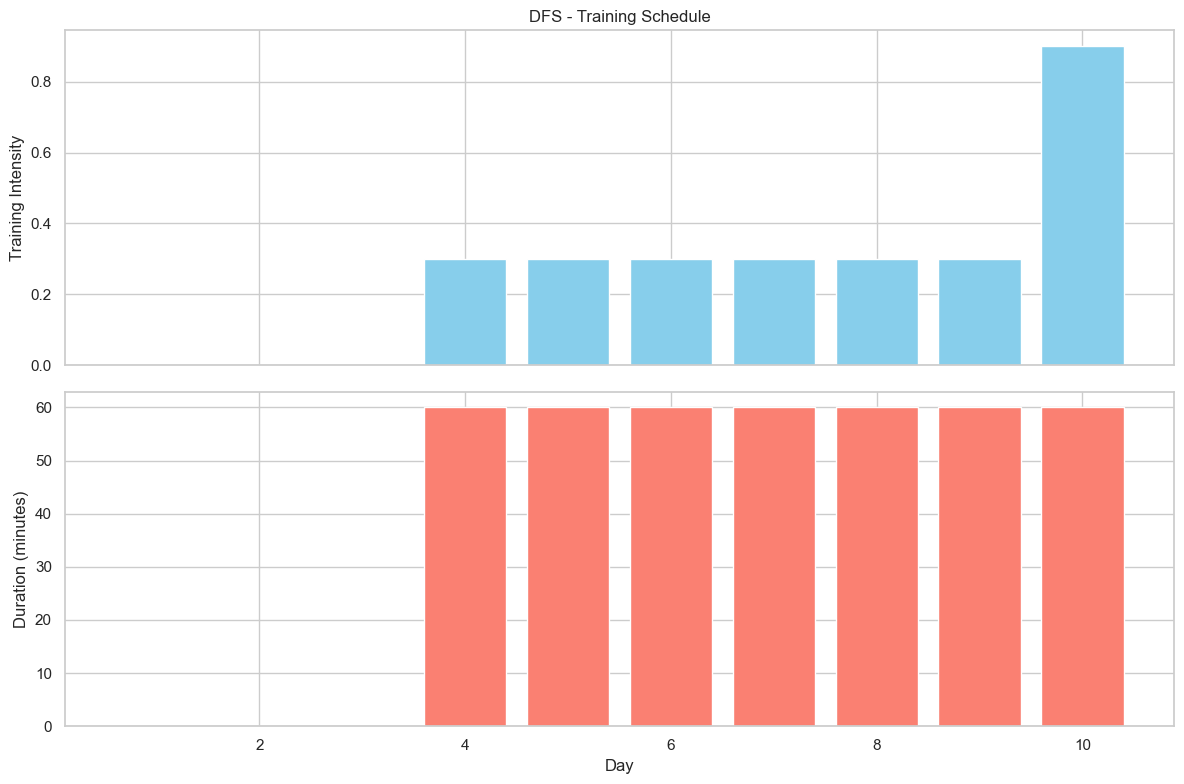

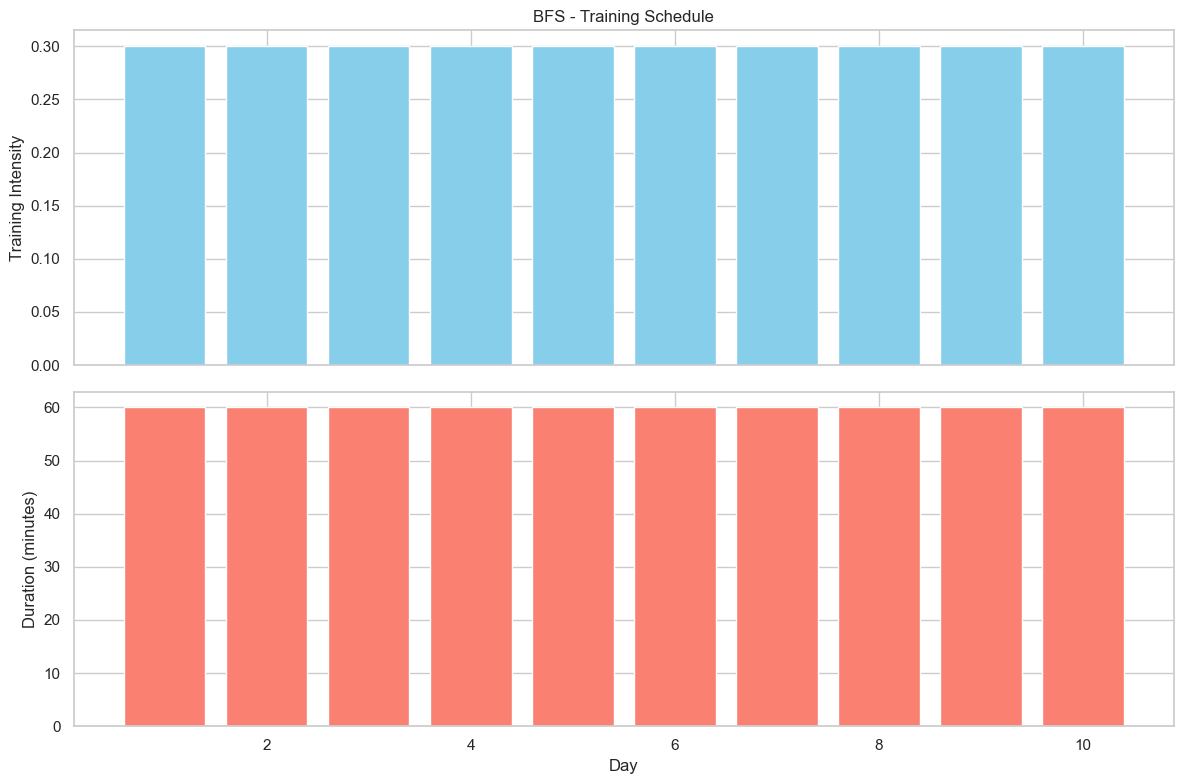

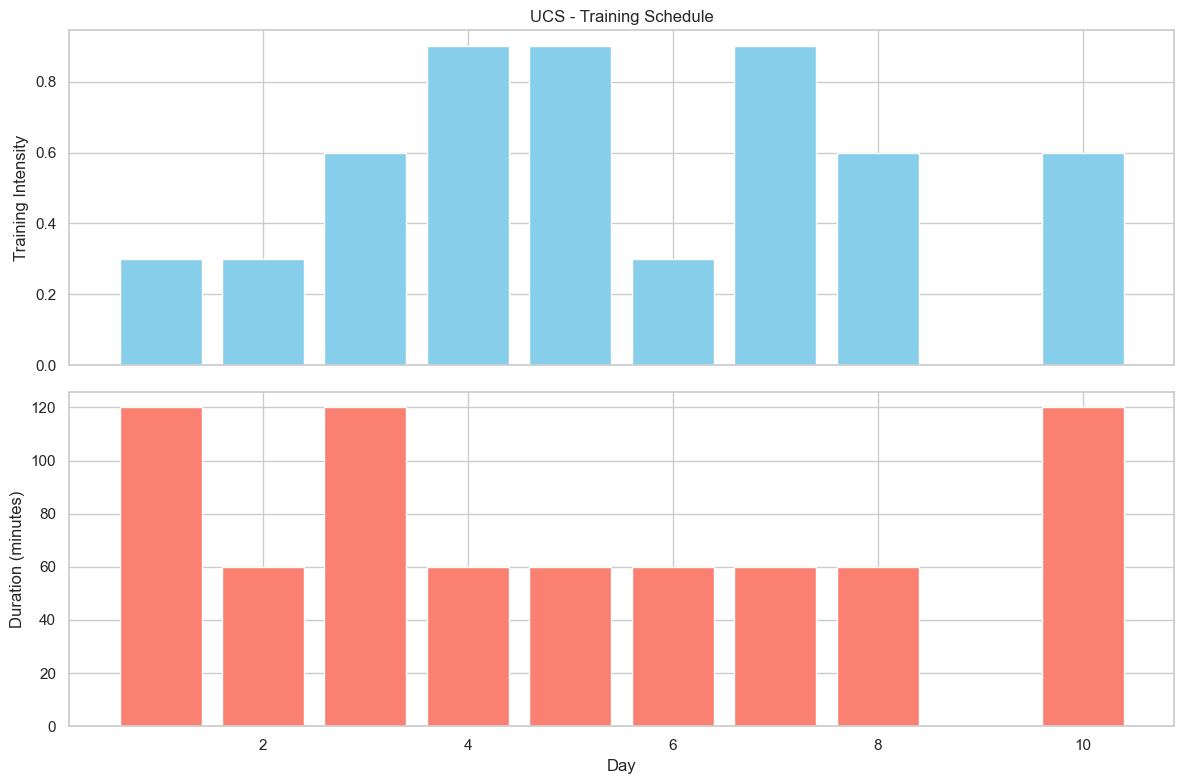

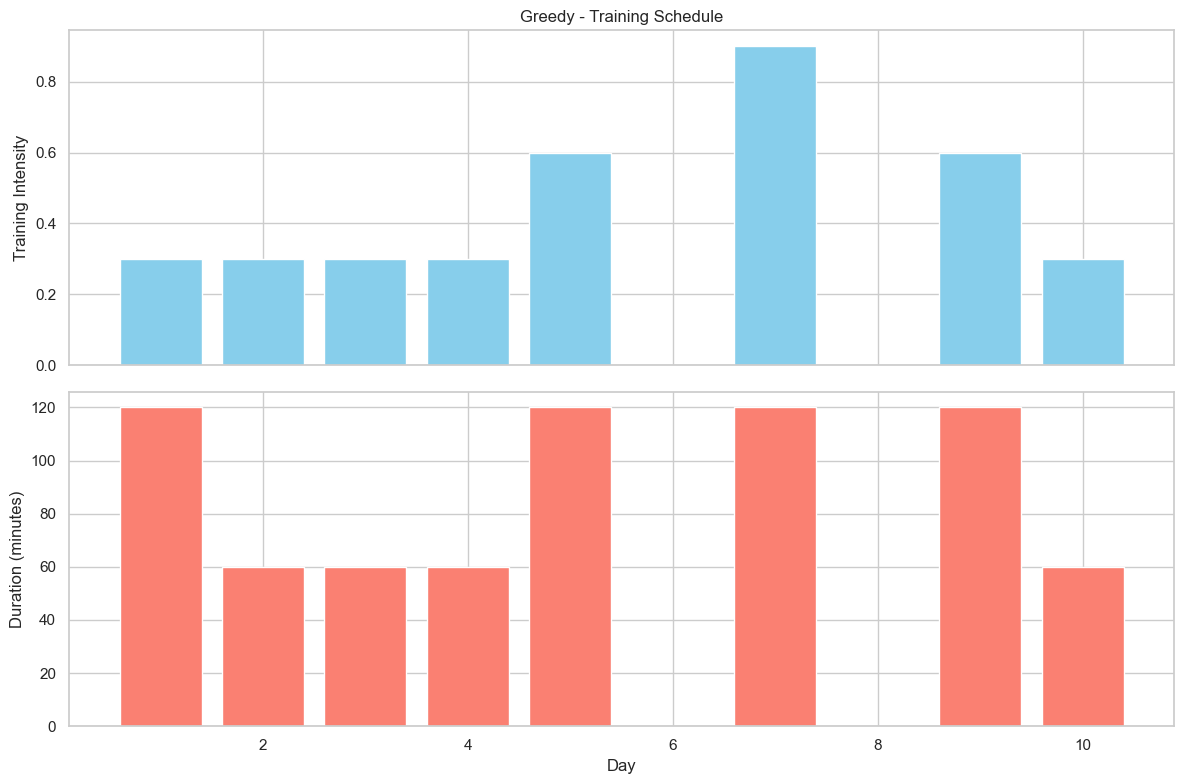

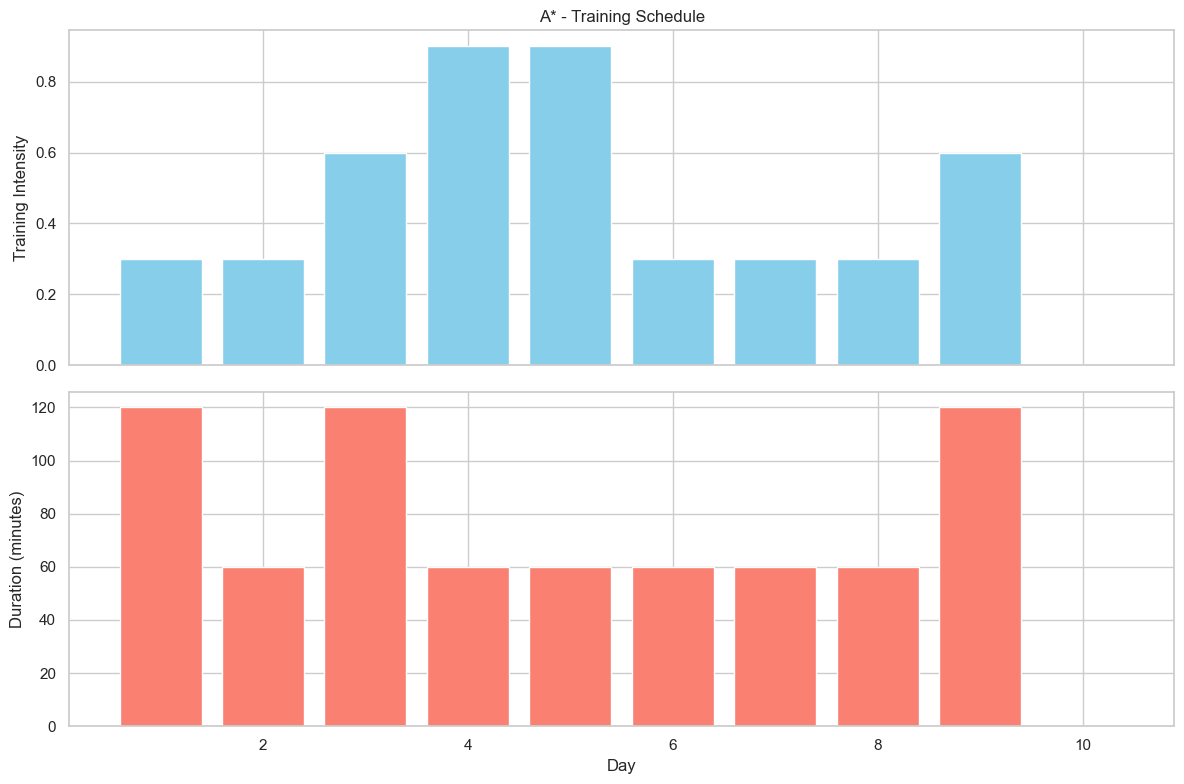

In [26]:
def visualize_schedule(evaluation, title):
    if evaluation is None or not evaluation['actions']:
        print(f"No schedule available for {title}")
        return
    
    actions = evaluation['actions']
    intensities = [action[0] for action in actions]
    durations = [action[1] for action in actions]
    days = list(range(1, len(actions) + 1))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot intensities
    ax1.bar(days, intensities, color='skyblue')
    ax1.set_ylabel('Training Intensity')
    ax1.set_title(f'{title} - Training Schedule')
    ax1.grid(True, axis='y')
    
    # Plot durations
    ax2.bar(days, durations, color='salmon')
    ax2.set_xlabel('Day')
    ax2.set_ylabel('Duration (minutes)')
    ax2.grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()

# Visualize each algorithm's schedule
for eval in evaluations:
    visualize_schedule(eval, eval['algorithm'])

## Combined Training Schedule Comparison

Let's create a side-by-side comparison of all training schedules.

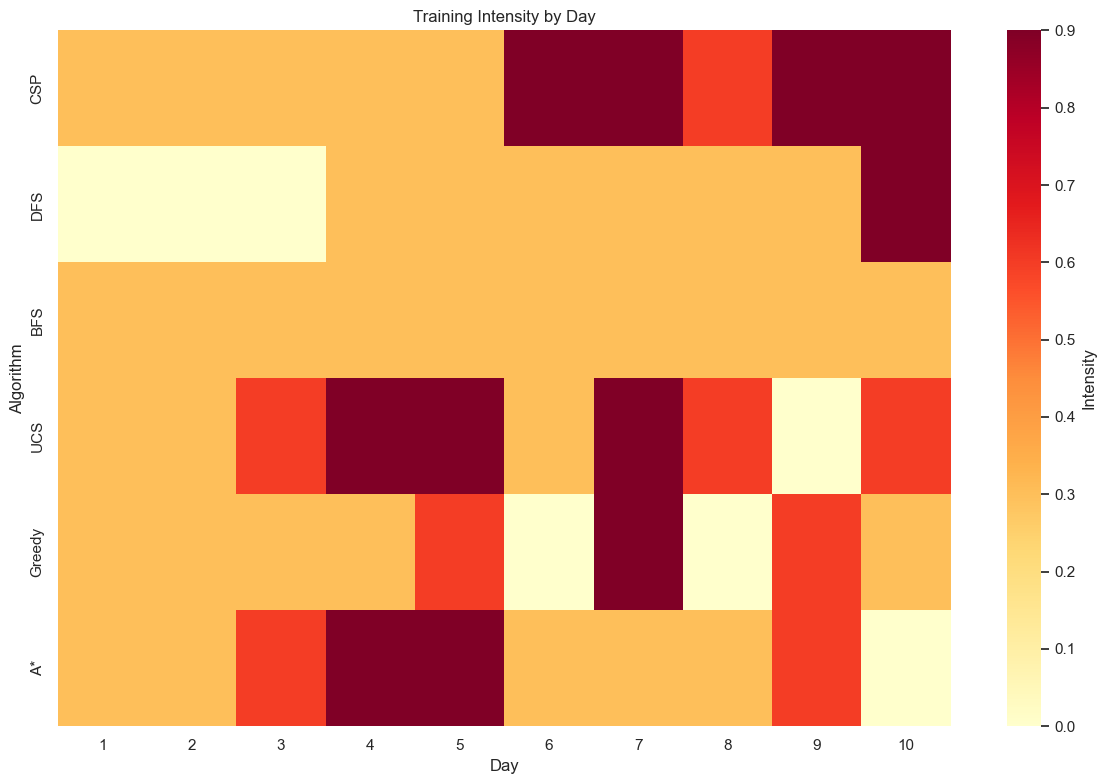

In [27]:
# Create a heatmap showing intensity across days for each algorithm
plt.figure(figsize=(12, 8))

# Prepare data for heatmap
intensity_data = []
algorithm_labels = []

for eval in evaluations:
    if eval and eval['actions']:
        # Get intensities from actions
        intensities = [action[0] for action in eval['actions']]
        # Pad to ensure all are the same length
        while len(intensities) < TARGET_DAY:
            intensities.append(0)
        intensity_data.append(intensities[:TARGET_DAY])
        algorithm_labels.append(eval['algorithm'])

if intensity_data:
    # Create a heatmap
    # Store the return value from sns.heatmap() and use the colorbar parameter
    heatmap = sns.heatmap(intensity_data, cmap="YlOrRd", 
                 xticklabels=list(range(1, TARGET_DAY+1)),
                 yticklabels=algorithm_labels,
                 cbar_kws={'label': 'Intensity'})
    plt.title('Training Intensity by Day')
    plt.xlabel('Day')
    plt.ylabel('Algorithm')
    plt.tight_layout()
    plt.show()
else:
    print("No data available for heatmap")

## Schedule Property Comparison

Let's compare the rest days, high intensity days, and total workload across algorithms.

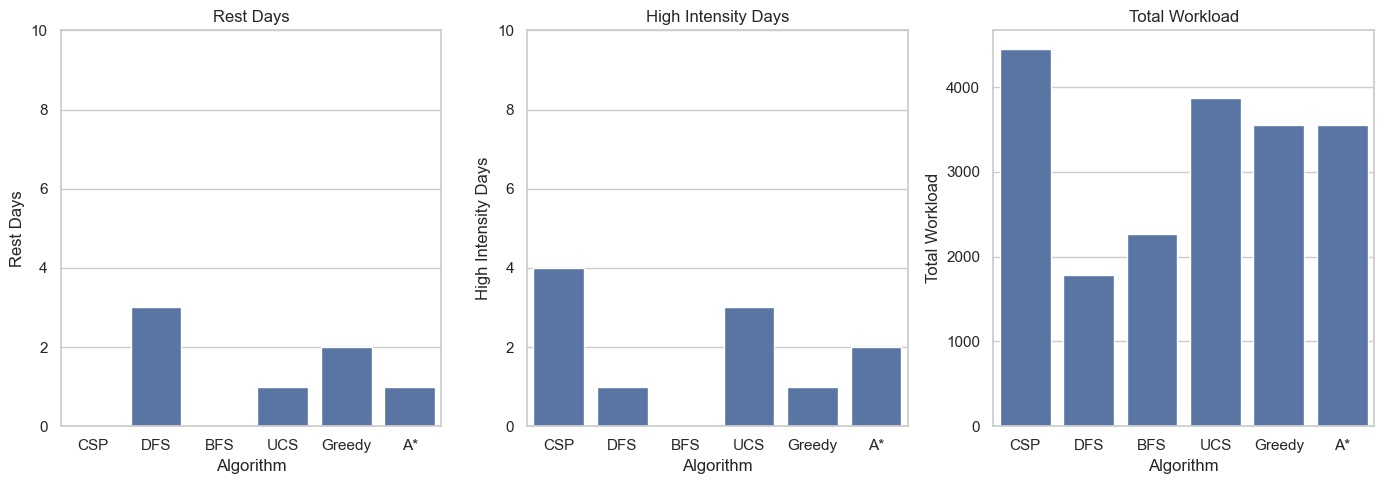

In [28]:
# Plot rest days comparison
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
sns.barplot(x='Algorithm', y='Rest Days', data=comparison_df)
plt.title('Rest Days')
plt.ylim(0, TARGET_DAY)

# Plot high intensity days comparison
plt.subplot(1, 3, 2)
sns.barplot(x='Algorithm', y='High Intensity Days', data=comparison_df)
plt.title('High Intensity Days')
plt.ylim(0, TARGET_DAY)

# Plot total workload comparison
plt.subplot(1, 3, 3)
sns.barplot(x='Algorithm', y='Total Workload', data=comparison_df)
plt.title('Total Workload')

plt.tight_layout()
plt.show()

## Radar Chart Comparison

Let's use a radar chart to visualize multiple metrics at once.

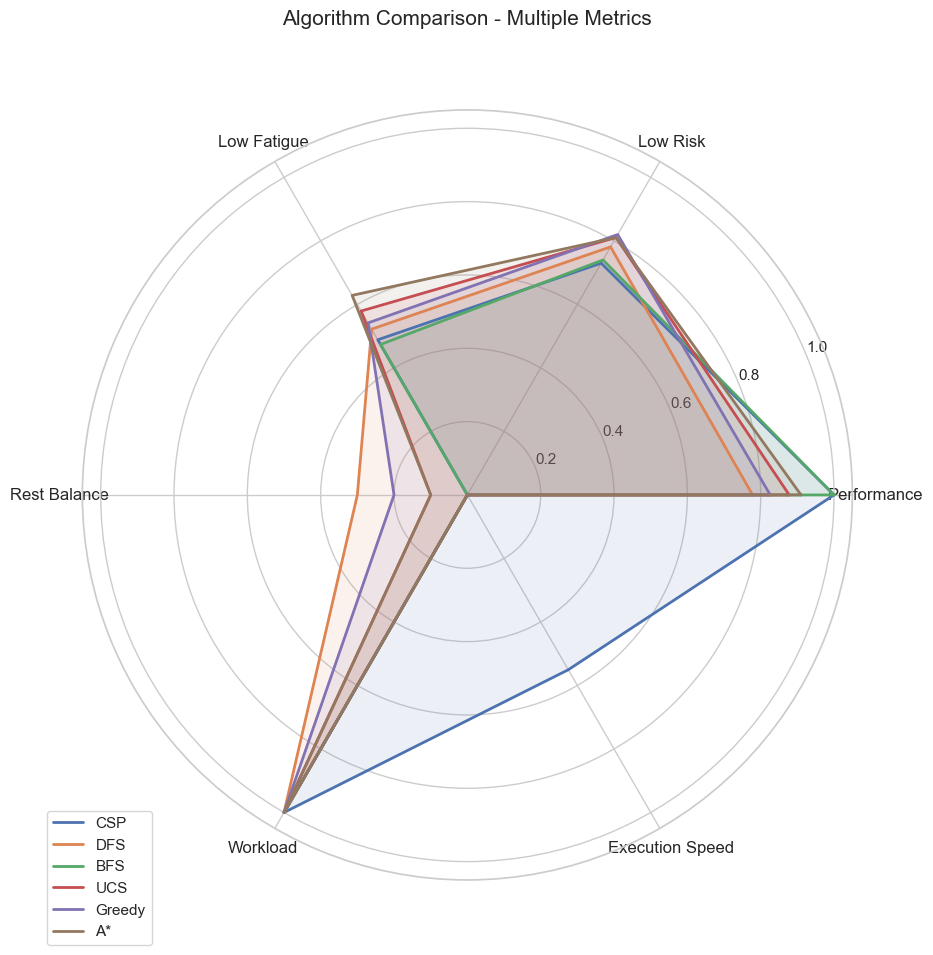

In [29]:
def radar_chart(data, categories, title):
    # Number of variables
    N = len(categories)
    
    # Compute angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories, size=12)
    
    # Draw the chart for each algorithm
    for i, (algo, values) in enumerate(data.items()):
        values_closed = values + values[:1]  # Close the loop
        ax.plot(angles, values_closed, linewidth=2, linestyle='solid', label=algo)
        ax.fill(angles, values_closed, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(title, size=15, y=1.1)
    
    return fig, ax

# Prepare data for radar chart - normalize all metrics to a 0-1 scale
radar_data = {}
categories = ['Performance', 'Low Risk', 'Low Fatigue', 'Rest Balance', 'Workload', 'Execution Speed']

for eval in evaluations:
    algorithm = eval['algorithm']
    
    # Get algorithm execution time
    if algorithm == 'CSP':
        exec_time = csp_result['execution_time']
    elif algorithm == 'DFS':
        exec_time = dfs_result['execution_time']
    elif algorithm == 'BFS':
        exec_time = bfs_result['execution_time']
    elif algorithm == 'UCS':
        exec_time = ucs_result['execution_time']
    elif algorithm == 'A*':
        exec_time = astar_result['execution_time']
    else:  # Greedy
        exec_time = greedy_result['execution_time']
    
    # Normalize metrics
    perf_norm = eval['final_performance'] / 10  # Performance on 0-10 scale
    risk_norm = 1 - (eval['final_risk'] / 1)  # Invert risk (lower is better)
    fatigue_norm = 1 - (eval['final_fatigue'] / 5)  # Invert fatigue (lower is better)
    rest_norm = eval['rest_days'] / TARGET_DAY  # Rest day proportion
    workload_norm = min(1.0, eval['total_workload'] / 1000)  # Cap at reasonable value
    speed_norm = 1 - min(1.0, exec_time / max(1, csp_result['execution_time'], greedy_result['execution_time']))  # Invert time (lower is better)
    
    radar_data[algorithm] = [perf_norm, risk_norm, fatigue_norm, rest_norm, workload_norm, speed_norm]

# Create the radar chart
if radar_data:
    radar_chart(radar_data, categories, 'Algorithm Comparison - Multiple Metrics')